# Predicción de Series Temporales
# Amazon's DeepAR

## Importing the data

In [3]:
import pandas as pd

# cogemos los datos de las visitas. Agrego por el índice y las sumamos. Al final obtengo la variable fecha y la 
# variable y

y = pd.read_csv('/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/data/Class/air_visit_data.csv.zip')
y = y.pivot(index='visit_date', columns='air_store_id')['visitors']
y = y.fillna(0)
y = pd.DataFrame(y.sum(axis=1))

y = y.reset_index(drop=False)
y.columns = ['date', 'y']


In [4]:
pip install --upgrade mxnet~=1.7

     |████████████████████████████████| 34.9 MB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mxnet==1.7.0.post2

     |████████████████████████████████| 30.2 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: mxnet
    Found existing installation: mxnet 1.8.0.post0
    Uninstalling mxnet-1.8.0.post0:
      Successfully uninstalled mxnet-1.8.0.post0
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install gluonts

     |████████████████████████████████| 2.1 MB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Preparing the data format requered by the gluonts library

In [7]:
# para preparar los datos 

from gluonts.dataset.common import ListDataset

# creamos primero la fecha de comienzo. Muy importante en Timestamp
start = pd.Timestamp("01-01-2016", freq="H")
# le digo cual va a ser el training. 
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': y.loc[:450,'y'], 'start': start}], freq='H')
# test dataset: use the whole dataset, add "target" and "start" fields
# en el test, el target es la y justamente
test_ds = ListDataset([{'target': y['y'], 'start': start}],freq='H')


/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_805/2266088250.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start = pd.Timestamp("01-01-2016", freq="H")


In [8]:
train_ds.list_data

[{'target': 0       1033.0
  1       1764.0
  2       2368.0
  3       3326.0
  4       3927.0
          ...   
  446    15101.0
  447    15879.0
  448    20720.0
  449    22836.0
  450    14459.0
  Name: y, Length: 451, dtype: float64,
  'start': Timestamp('2016-01-01 00:00:00', freq='H')}]

In [9]:
# en el test cogemos todos los datos y en training no todos. El modelo debe trabajar con conjuntos de datos grande
test_ds.list_data

[{'target': 0       1033.0
  1       1764.0
  2       2368.0
  3       3326.0
  4       3927.0
          ...   
  473    13489.0
  474    14607.0
  475    13990.0
  476    19624.0
  477    21245.0
  Name: y, Length: 478, dtype: float64,
  'start': Timestamp('2016-01-01 00:00:00', freq='H')}]

## Fitting the default DeepAR model

In [10]:
# cogemos de la librería DeepAREstimator

from gluonts.model.deepar import DeepAREstimator
#from gluonts.trainer import Trainer

# me cojo el trainer
from gluonts.mx.trainer import Trainer
import mxnet as mx
import numpy as np

# ponemos la semilla tanto en numpy como en deeplearning
np.random.seed(7)
mx.random.seed(7)

# le decimos como vamos a estmar. Le damos información sobre como queremos estimar.
estimator = DeepAREstimator(
    prediction_length=28,
    context_length=100,
    freq='H',
    # el mio no tiene y no le pongo gpu
    trainer=Trainer(#ctx="gpu", # remove if running on windows
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

# hemos puesto 5 épocas luego hace 5 veces. podemos poner más pero el tiempo de cómputo aumenta

# una vez definido el estimador, hacemos el training

predictor = estimator.train(train_ds)


/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is depre

## Prediction

In [26]:
# cada vez que ejecito las predicciones, estas cambian porque usan números aleatorios

predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
# cuando usas técnicas probabílisticas, la predicción es la mediana, no la media
predictions = predictions.quantile(0.5)


/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


In [27]:
predictions

array([14674.09 , 11244.778, 14112.286, 14639.898, 13894.899, 18023.281,
       18963.299, 12771.591, 11319.183, 13731.326, 13673.661, 14038.79 ,
       19105.182, 21612.607, 15805.102, 11748.775, 12808.459, 13367.134,
       12600.224, 18485.588, 21517.95 , 14096.249, 10590.034, 12582.497,
       13744.589, 13796.259, 19100.736, 21303.178], dtype=float32)

##  R2 score and prediction graph

0.8529686987344844


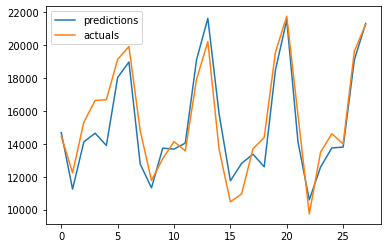

In [28]:
from sklearn.metrics import r2_score
print(r2_score( list(test_ds)[0]['target'][-28:], predictions))

import matplotlib.pyplot as plt
plt.plot(predictions)
plt.plot(list(test_ds)[0]['target'][-28:])
plt.legend(['predictions', 'actuals'])
plt.show()


## Probability forecast graph

/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


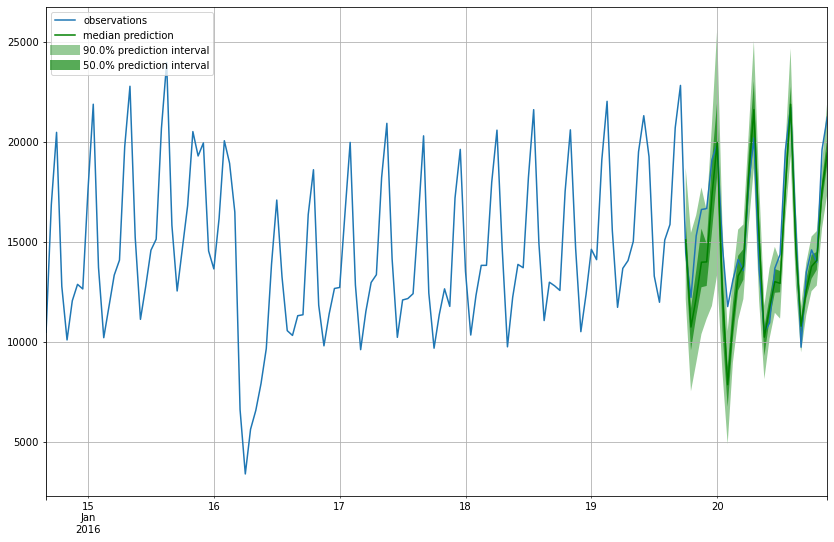

In [31]:
# gráficos probabilísticos

from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

ts_entry = tss[0]
forecast_entry = forecasts[0]

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(14, 9))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)
plt.show()

# lo verde es la predicción y lo azul es lo real. Cuando lo azul se sale de los intervalos de confianza, es malo.
# nos tenemos que fijar que ahora, la predicción es la mediana


## Preparing holidays and reservations data and adding them into the ListDataset

In [36]:
# vamos a incluir las reservas y las fiestas con el fin de ver si mejora el modelo

X_reservations = pd.read_csv('/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/data/Class/air_reserve.csv.zip')
X_reservations['visit_date'] = pd.to_datetime(X_reservations['visit_datetime']).dt.date
X_reservations = pd.DataFrame(X_reservations.groupby('visit_date')['reserve_visitors'].sum())
X_reservations = X_reservations.reset_index(drop = False)

# Convert to datatime for merging correctly
y.date = pd.to_datetime(y.date)
X_reservations.visit_date = pd.to_datetime(X_reservations.visit_date)

# Merging and filling missing dates with 0
y = y.merge(X_reservations, left_on = 'date', right_on =  'visit_date', how = 'left').fillna(0)

# Preparing and merging holidays data
holidays = pd.read_csv('/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/data/Class/date_info.csv.zip')
holidays.calendar_date = pd.to_datetime(holidays.calendar_date)
y = y.merge(holidays, left_on = 'date', right_on = 'calendar_date', how = 'left').fillna(0)

# Preparing the ListDatasets

train_ds = ListDataset([{
    'target': y.loc[:450,'y'],
    'start': start,
    'feat_dynamic_real': y.loc[:450,['reserve_visitors', 'holiday_flg']].values
    }], freq='H')

test_ds = ListDataset([{
    'target': y['y'], 
    'start': start, 
    'feat_dynamic_real': y.loc[:,['reserve_visitors', 'holiday_flg']].values
    }],freq='H')


## Same code for fitting a different model: this model contains the two additional regressors

In [37]:
np.random.seed(7)
mx.random.seed(7)

# Build and fit model
estimator = DeepAREstimator(
    prediction_length=28,
    context_length=100,
    freq='H',
    trainer=Trainer(# ctx="gpu", # remove if running on windows
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

predictor = estimator.train(train_ds)

# Make Predictions
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

# Compute and print R2 score
print(r2_score( list(test_ds)[0]['target'][-28:], predictions))

# el r^2 nos sale muy parecido al obtenido antes.


/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████| 100/100 [00:11<00:00,  8.53it/s, epoch=5/5, avg_epoch_loss=7.92]
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in 

0.8516763609510049


## Tuning the hyperparameters

In [40]:
# los de Amazon no han conseguido el éxito de google ni facebook con su modelo.

np.random.seed(7)
mx.random.seed(7)

results = []
# estos son parámetros que determinan el modelo y por tanto la calidad.
# es como un grid que nos permite mejorar el modelo
for learning_rate in [1e-4, 1e-2]:
  for num_layers in [2, 5]:
    for num_cells in [30, 100]:

      estimator = DeepAREstimator(
          prediction_length=28,
          freq="H",
          trainer=Trainer(#ctx="gpu", # remove if on Windows
                          epochs=10,
                          learning_rate=learning_rate,
                          num_batches_per_epoch=100
                        ),
          num_layers = num_layers,
          num_cells = num_cells,
      )

      predictor = estimator.train(train_ds)

      predictions = predictor.predict(test_ds)

      r2 = r2_score(list(predictions)[0].quantile(0.5), list(test_ds)[0]['target'][-28:])
      result = [learning_rate, num_layers, num_cells, r2]
      print(result)
      results.append(result)


  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|███████| 100/100 [00:05<00:00, 19.74it/s, epoch=10/10, avg_epoch_loss=8.43]
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in 

[0.0001, 2, 30, 0.5796555451505093]


  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
 75%|██████▊  | 75/100 [00:08<00:02,  9.32it/s, epoch=3/10, avg_epoch_loss=8.72]


KeyboardInterrupt: 